# IE 360 Statistical Forecasting and Time Series
# Homework 2

I've used Python as programming language. Needed modules:
- pandas
- skforecast
- numpy
- statsmodels
- sklearn

These modules can be install using pip. Example for skforecast : "pip install skforecast"

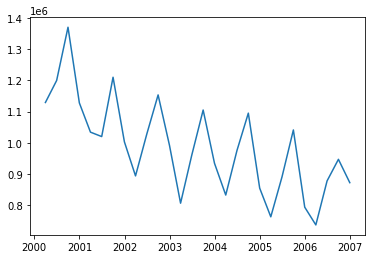

In [68]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from numpy import log
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
data_raw = pd.read_csv("IE360_Spring22_HW2_data.csv", dtype='string')

#Data preprocessing
data_raw.rename(columns = {'Unleaded Gasoline Sale (UGS)':'UGS', 
    '# LPG Vehicles (NLPG)':'NLPG', 'Price of Unleaded Gasoline (PU)':'PU', 
    'Price of Diesel Gasoline (PG)':'PG', '# Unleaded Gasoline Vehicles (NUGV)':'NUGV', 
    '# of Diesel Gasoline Vehicles (NDGV)':'NDGV' , 'GNP Agriculture' : 'GNPA',
    'GNP Commerce':'GNPC', 'GNP Total':'GNP',
    }, inplace = True)
data_raw['Quarter'] = pd.date_range("2000-01-01", "2007-12-31",freq='Q')
cols = data_raw.columns
data_raw = data_raw.replace(' ','', regex=True)
data_raw[cols[1:]] = data_raw[cols[1:]].astype(float)

df_test = data_raw[-4:]

df = data_raw.drop(data_raw.tail(4).index)
df = df.drop(['NLPG'], axis=1)
cols = df.columns


#Plot the time series UGS
plt.plot(df['Quarter'],df['UGS'])

As you can see from above plot, time series looks non-stationary. However, when I did statistical analyis and hypothesis testing using Augmented Dickey-Fuller test results showed it is stationary. 

In [69]:
X = df['UGS'].values

X = log(X)
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]

mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=13.871080, mean2=13.711945
variance1=0.016982, variance2=0.014713


In above, I've split dataframe into two and compared their mean and variance. As you can see there is no significant difference. For the Augmented Dickey-Fuller test I've used to below code.

In [70]:
vals = df['UGS'].values
result = adfuller(df['UGS'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.266273131348114
p-value: 0.016455044163734462
Critial Values:
   1%, -3.7377092158564813
Critial Values:
   5%, -2.9922162731481485
Critial Values:
   10%, -2.635746736111111


The null hypothesis is that the time series is non-stationary. I've choosen 95% confidence, meaning that p-value must be smaller than or equal to 0.05 to reject the null hypothesis. As seen above p-value is 0.016 and we can reject the null hypothesis. So, time series may be stationary.

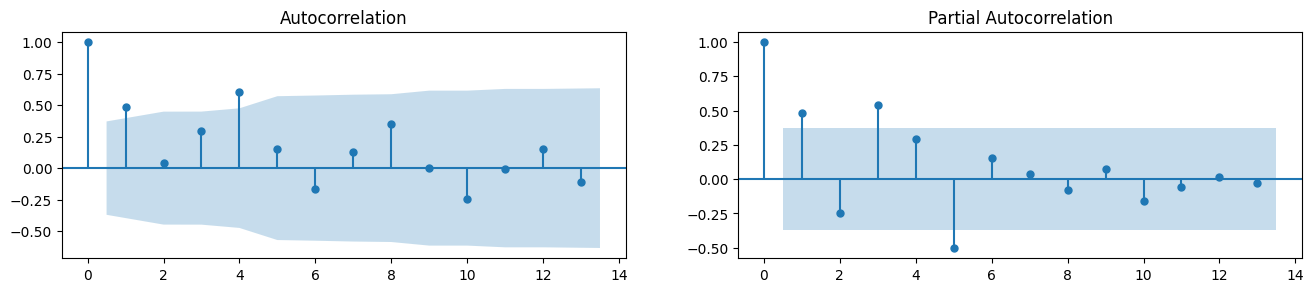

In [71]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(vals,  lags=13,ax=axes[0])
plot_pacf(vals, lags=13, method='ywm',ax=axes[1])
plt.show()

The best lag values are 1 and 4. Meaning that either a single quarter or a whole year should be used for frequency. However, 4 falls out of the confidence interval in partial autocorrelation function, so, AR(1) should be used for autoregressive models.

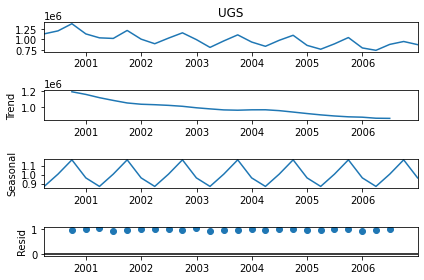

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose
df.set_index('Quarter', inplace = True)

decompose_result_mult = seasonal_decompose(df['UGS'], model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
df['trend'] = trend
df['seasonal'] = seasonal
decompose_result_mult.plot()
plt.show()

I've used seasonal decomposition method for finding seasonal, trend and  residual variables. I've choosen multiplicative model since it occured to me that seasonal variaton decreases over time. I've also appended the variable to the data frame as columns.

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

reg = LinearRegression()
forecaster = ForecasterAutoreg(
                regressor = reg,
                lags = 4
                )
forecaster.fit(y=df['UGS'], exog=df[['RNUV','PU','PG','NUGV','NDGV','GNP']])
print(forecaster)


ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [1 2 3 4] 
Window size: 4 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['RNUV', 'PU', 'PG', 'NUGV', 'NDGV', 'GNP'] 
Training range: [0, 27] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-05-10 23:33:11 
Last fit date: 2022-05-10 23:33:11 
Skforecast version: 0.4.3 



c:\python39\lib\site-packages\skforecast\utils\utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\python39\lib\site-packages\skforecast\utils\utils.py:358: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\python39\lib\site-packages\skforecast\utils\utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [74]:

predictions = forecaster.predict(steps=4, exog=df_test[['RNUV','PU','PG','NUGV','NDGV','GNP']])
print(predictions.head())

28    710308.340478
29    830751.919069
30    966741.453967
31    820653.002048
Name: pred, dtype: float64


I've used ForecasterAutoRegressive model with LinearRegression as regressor. I've used every variable apart from GNPA and GNPC since GNP Total is sufficient. I've predicted the last 4 quarters. As you can see they are  710308.340478, 830751.919069 , 966741.453967 , 820653.002048. This predictions correlate with existing data because in every first quarter there is a significant decrease and there is an overall decrease in sales as shown in seasonal decomposition.